In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
#Retail Sales Forecasting

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
#Описова статистика

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9800.0,4900.500000,2829.160653,1.000,2450.750,4900.50,7350.250,9800.00
Postal Code,9789.0,55273.322403,32041.223413,1040.000,23223.000,58103.00,90008.000,99301.00
Sales,9800.0,230.769059,626.651875,0.444,17.248,54.49,210.605,22638.48


In [7]:
df.drop('Row ID', axis=1, inplace=True)
new_df = pd.DataFrame(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


In [9]:
#Нам потрібно перетворити це замовлення та дату доставки на дату й час

In [10]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [11]:
# Сортувати за датою замовлення
df.sort_values(by=['Order Date'], inplace=True, ascending=True)

In [12]:
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-04', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-06', '2015-01-06',
               '2015-01-06', '2015-01-06',
               ...
               '2018-12-29', '2018-12-29', '2018-12-29', '2018-12-30',
               '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30',
               '2018-12-30', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=9800, freq=None)

In [13]:
df.isnull().mean()*100

Order ID         0.000000
Ship Date        0.000000
Ship Mode        0.000000
Customer ID      0.000000
Customer Name    0.000000
Segment          0.000000
Country          0.000000
City             0.000000
State            0.000000
Postal Code      0.112245
Region           0.000000
Product ID       0.000000
Category         0.000000
Sub-Category     0.000000
Product Name     0.000000
Sales            0.000000
dtype: float64

In [14]:
df[df['Postal Code'].isnull()]

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,
2016-11-07,CA-2016-162887,2016-11-09,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
2016-11-08,CA-2016-117086,2016-11-12,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",4404.90
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
2017-04-06,US-2017-150140,2017-04-10,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28


In [15]:
#Всі відсутні поштові індекси з одного міста, Берлінгтон, Вермонт.

In [16]:
df['Postal Code'] = df['Postal Code'].fillna(5401)

In [17]:
df.isnull().sum()

Order ID         0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

In [18]:
df.head()

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,
2015-01-03,CA-2015-103800,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
2015-01-05,CA-2015-141817,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143.0,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


In [19]:
#Data Visualizations

In [20]:
top_customers = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(20)

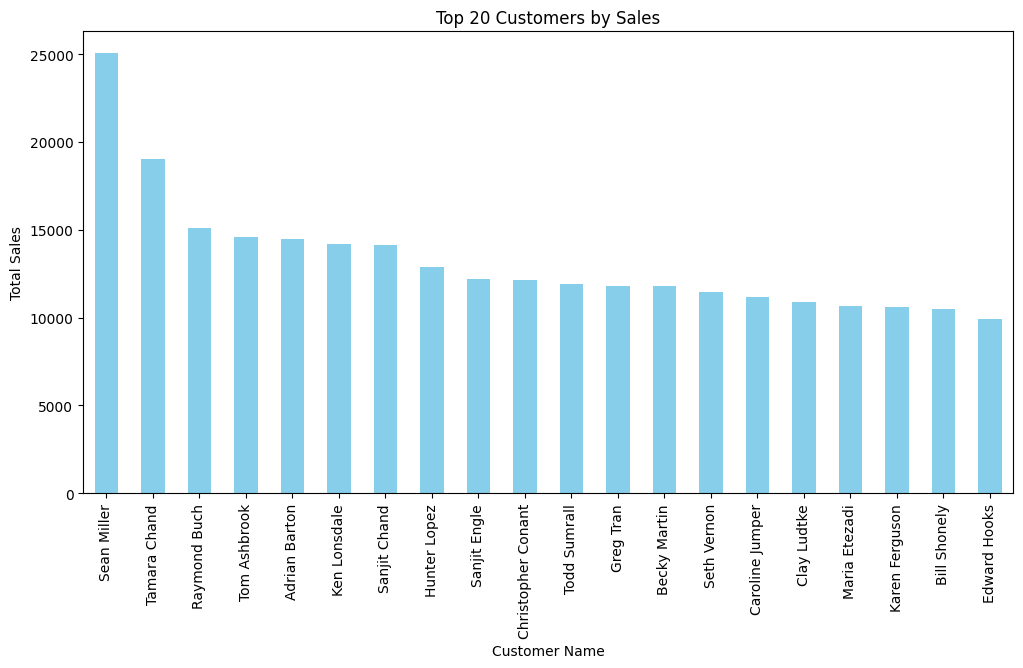

In [21]:
rcParams['figure.figsize'] = 12, 6
top_customers.plot(kind='bar', color='skyblue')
plt.title('Top 20 Customers by Sales')
plt.xlabel('Customer Name')
plt.ylabel('Total Sales')
plt.show()

In [22]:
tech_df = pd.DataFrame(df.loc[df['Category'] == 'Technology'])
furniture_df = pd.DataFrame(df.loc[df['Category'] == 'Furniture'])
office_df = pd.DataFrame(df.loc[df['Category'] == 'Office Supplies'])

In [23]:
temp_df = df
resample = 'MS'

In [24]:
new_df = pd.DataFrame(temp_df['Sales']) 
new_df = pd.DataFrame(new_df['Sales'].resample(resample).mean())
new_df = new_df.interpolate(method='linear')
new_df.head()

,Sales
Order Date,
2015-01-01,184.489701
2015-02-01,98.258522
2015-03-01,358.479201
2015-04-01,214.668115
2015-05-01,195.407463


In [25]:
# Train / Test / Validate Split
train_df, test_df, val_df = np.split(
    new_df['Sales'].sample(frac=1), 
    [int(.6*len(new_df['Sales'])), int(.8*len(new_df['Sales']))]
    )

C:\Python\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [26]:
# Нормалізуйемо
# Do not include test or val in mean calculation to avoid information leakage
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [27]:
def analyze_time_series(time_series_df):
  rcParams['figure.figsize'] = 18, 8
  decomposition = sm.tsa.seasonal_decompose(time_series_df, model='additive')
  fig = decomposition.plot()
  plt.show()

In [28]:
#Тепер потрібно знайти оптимальне поєднання цих параметрів. Ми можемо зробити це, виконавши швидкий пошук у сітці та шукаючи мінімальний AIC, який представляє відносний обсяг інформації, втраченої моделлю.

In [29]:
#Побудуйте часовий ряд і розкладіть його на тренд і сезонність

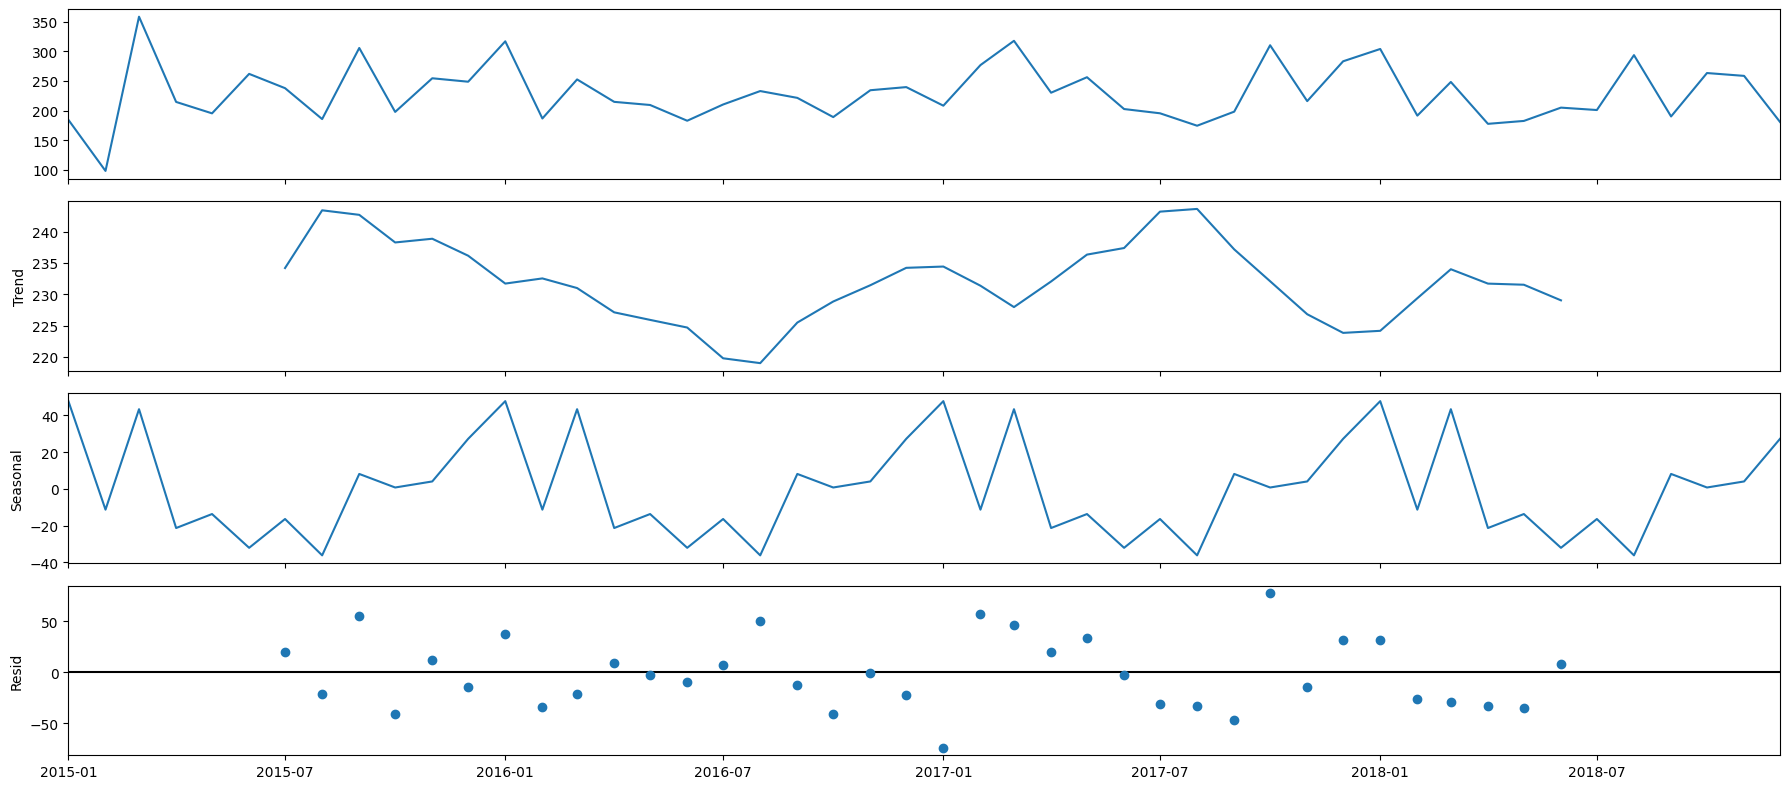

In [30]:
analyze_time_series(new_df)

In [31]:
#Цей графік демонструє деяку чітку сезонність і загальну нестабільність продажів.

In [32]:
#Time Series Analysis

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [34]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_df,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:597.6634244866568


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:597.6634244866568
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:597.6634244866568
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(0, 0, 1, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(0, 1, 0, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(0, 1, 1, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(1, 0, 0, 12)12 - AIC:529.3704763081976


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(0, 1, 0)x(1, 0, 1, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(1, 1, 0, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 0)x(1, 1, 1, 12)12 - AIC:529.3704763081976
SARIMAX(0, 1, 1)x(0, 0, 0, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(0, 0, 1, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(0, 1, 0, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(1, 0, 0, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.2113518627071


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(0, 1, 1)x(1, 1, 0, 12)12 - AIC:470.2113518627071
SARIMAX(0, 1, 1)x(1, 1, 1, 12)12 - AIC:470.2113518627071
SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(0, 0, 1, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(0, 1, 0, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(0, 1, 1, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(1, 0, 1, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 - AIC:541.9472243525513
SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 - AIC:541.9472243525513


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(1, 0, 1)x(0, 0, 0, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(0, 0, 1, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(0, 1, 0, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(0, 1, 1, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(1, 0, 0, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(1, 0, 1, 12)12 - AIC:498.79301757670305


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(1, 0, 1)x(1, 1, 0, 12)12 - AIC:498.79301757670305
SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 - AIC:498.79301757670305
SARIMAX(1, 1, 0)x(0, 0, 0, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(0, 0, 1, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(0, 1, 0, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(0, 1, 1, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(1, 0, 0, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(1, 1, 0, 12)12 - AIC:510.3638845671393
SARIMAX(1, 1, 0)x(1, 1, 1, 12)12 - AIC:510.3638845671393


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(0, 0, 1, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(0, 1, 0, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(1, 0, 0, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 - AIC:471.71636476162075


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown 

SARIMAX(1, 1, 1)x(1, 1, 0, 12)12 - AIC:471.71636476162075
SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:471.71636476162075


C:\Python\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [35]:
mod = sm.tsa.statespace.SARIMAX(new_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0997      0.250     -0.399      0.690      -0.590       0.390
ma.L1         -1.0000   1170.347     -0.001      0.999   -2294.838    2292.838
ar.S.L12      -0.5849      0.177     -3.301      0.001      -0.932      -0.238
sigma2      2481.6349    2.9e+06      0.001      0.999   -5.69e+06     5.7e+06


In [36]:
#Time Series Forecasting

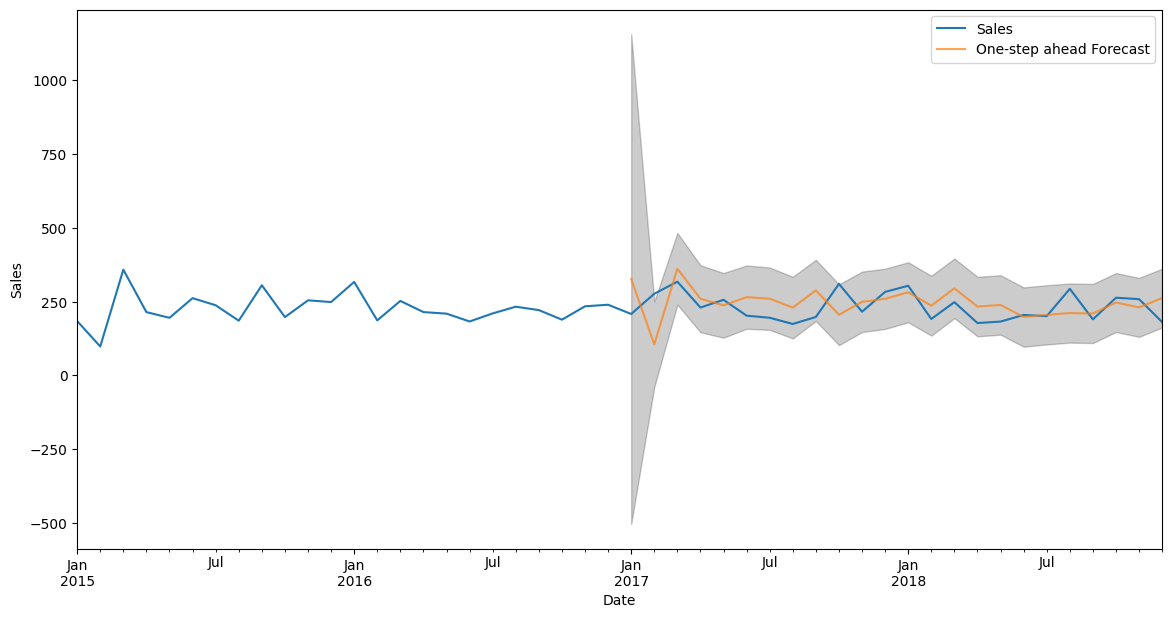

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = new_df['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [38]:
y_forecasted = pred.predicted_mean
y_truth = new_df['2017-01-01':]

mse = mean_squared_error(y_forecasted, y_truth)
rmse = sqrt(mse)
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of the forecasts is 65.88


In [39]:
forecast = results.forecast(steps=7) # створення прогнозу на 7 днів пізніше останньої дати в стовпці'Order Date'
print(forecast.astype('int'))

2019-01-01    259
2019-02-01    244
2019-03-01    292
2019-04-01    212
2019-05-01    229
2019-06-01    207
2019-07-01    201
Freq: MS, Name: predicted_mean, dtype: int32


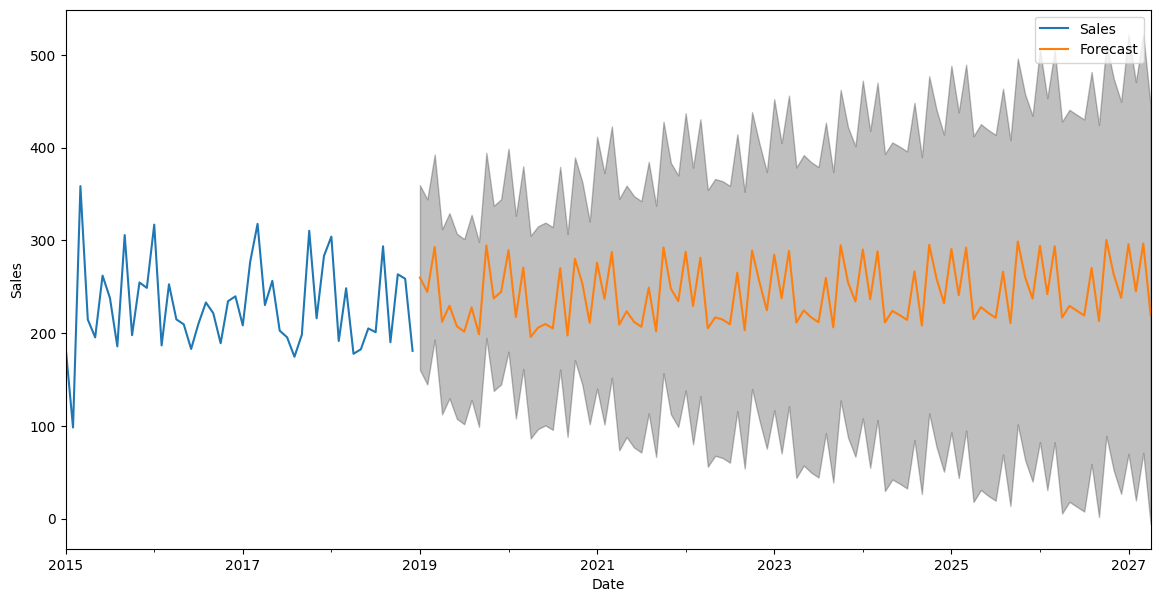

In [40]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = new_df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [41]:
import joblib
import pickle

# Збереження моделі
joblib.dump(results, 'my_model.pkl')

# Збереження середнього значення та стандартного відхилення
with open('train_mean.pkl', 'wb') as f:
    pickle.dump(train_mean, f)

with open('train_std.pkl', 'wb') as f:
    pickle.dump(train_std, f)